# Sentiment classification with an RNN

`imdb_reviews` dataset is a large movie review dataset. This dataset is for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. All the reviews have either a *positive* or *negative* sentiment.
Reference: http://ai.stanford.edu/~amaas/data/sentiment/

Each data sample contains:
* label (tf.int64)
* text (tf.string)

In [1]:
# Download tensorflow datasets
!pip install tensorflow_datasets

# Import libraries
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load the dataset


In [10]:
from tensorflow.keras.layers import GRU, LSTM, Dense, Input, TextVectorization, Embedding, Bidirectional, Conv1D, Flatten, MaxPooling1D

In [2]:
# Load the IMDB movie review dataset, return text (movie review) and label (positive/negative)
train_dataset, val_dataset, test_dataset = tfds.load(name="imdb_reviews", split=('train[:80%]', 'train[80%:]', 'test'), as_supervised=True)

print("Training set: ", len(train_dataset), "samples")
print("Validation set: ", len(val_dataset), "samples")
print("Test set: ", len(test_dataset), "samples")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQU9C8N/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQU9C8N/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQU9C8N/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Training set:  20000 samples
Validation set:  5000 samples
Test set:  25000 samples


In [3]:
# Show same samples in the training set
for example, label in train_dataset.take(3):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [4]:
### Convert Tensorflow Dataset to numpy arrays of feature vector X and label y

# Convert training set
train_ds_numpy = tfds.as_numpy(train_dataset) # Convert TF Dataset to an iterable of numpy array
train_numpy = np.vstack(list(train_ds_numpy)) # Stack to full numpy array
X_train = np.array(list(map(lambda x: x[0], train_numpy))) # Extract review (index 0) from numpy vector
y_train = np.array(list(map(lambda x: x[1], train_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector and convert grom string to number
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))

# Convert validation set
val_ds_numpy = tfds.as_numpy(val_dataset) # Convert TF Dataset to an iterable of numpy array
val_numpy = np.vstack(list(val_ds_numpy)) # Stack to full numpy array
X_val = np.array(list(map(lambda x: x[0], val_numpy))) # Extract review (index 0) from numpy vector
y_val = np.array(list(map(lambda x: x[1], val_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))

# Convert test set
test_ds_numpy = tfds.as_numpy(test_dataset) # Convert TF Dataset to an iterable of numpy array
test_numpy = np.vstack(list(test_ds_numpy)) # Stack to full numpy array
X_test = np.array(list(map(lambda x: x[0], test_numpy))) # Extract review (index 0) from numpy vector
y_test = np.array(list(map(lambda x: x[1], test_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (20000,)
y_train shape: (20000,)
X_val shape: (5000,)
y_val shape: (5000,)
X_test shape: (25000,)
y_test shape: (25000,)


# Encode the text
### Initialize and build the text vectorizer

In [5]:
### TextVectorization layer maps text features to integer sequences.
# Set vocabulary size for the training data
VOCAB_SIZE = 1000

# Initialize the TextVectorization layer for raw text encoding
text_encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE) # Maximum size of the vocabulary

# Feed training text to adapt() method to calculate the layer's vocabulary 
text_encoder.adapt(X_train)

In [6]:
# Show the first 20 tokens. After the padding ('') and unknown ([UNK]) tokens they're sorted by frequency.
vocab = np.array(text_encoder.get_vocabulary()) # Get the vocabulary of the training set after the adaptation
print("Vocabulary size:", vocab.shape)
vocab[:20] # Show the first 20 tokens (sorted by frequency) in the vocabulary

Vocabulary size: (1000,)


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

### Test the text vectorizer

In [7]:
### Example of how a text vectorization layer works. It maps strings to integers.

# Create the model that uses the text vectorization layer
model_encoder = tf.keras.models.Sequential()

# Creating an explicit input layer.
# It needs to have a shape of (1,) (because we need to guarantee that there is exactly one string input per batch),
model_encoder.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# The first (unique) layer in the model is the vectorization layer.
# After this layer, we have a tensor of shape (batch_size, max_len) containing vocab indices.
model_encoder.add(text_encoder)

# The model can map strings to integers, and you can add an embedding layer to map these integers to learned embeddings.
test_data = [["I want to drink"], ["I do not want to eat but I want to sleep"]]
model_encoder.predict(test_data)

# Note: The tensors of indices are zero-padded to the longest sequence in the batch,
# to make sure that all tensors of indices have the same size (for batching purpose).

1/1 [==============================] - 0s 210ms/step


array([[ 10, 179,   6,   1,   0,   0,   0,   0,   0,   0,   0],
       [ 10,  79,  22, 179,   6,   1,  19,  10, 179,   6,   1]])

### Text vectorization is not completely reversible

In [8]:
# Note: the vectorization process is not completely reversible due to the limited vocabulary size
print("Original: ", X_train[0])
print()
print("Round-trip: ", " ".join(vocab[text_encoder(X_train[0]).numpy()]))

Original:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

Round-trip:  this was an absolutely terrible movie dont be [UNK] in by [UNK] [UNK] or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not [UNK] this movies ridiculous storyline this movie is an early [UNK]

# GRU


In [ ]:
# Initialize a sequential model since all the layers in the model only have single input and produce single output
model = tf.keras.Sequential([
    text_encoder, # Text encoder layer, i.e., TextVectorization layer
    tf.keras.layers.Embedding( # Text embedding layer, i.e., turns positive integers (indexes) into dense vectors of fixed size.
        input_dim=len(text_encoder.get_vocabulary()), # Get the size of word vocabulary (positive integers), VOCAB_SIZE.
        output_dim=64, # Fixed size of the output embedding vectors which is fed as input of GRU layer.
        mask_zero=True), # Whether or not the input value 0 (the zero-padding) should be masked out
        # Hence if mask_zero = True, index 0 cannot be used in the vocabulary (input_dim = vocabulary size + 1)
    tf.keras.layers.GRU(units=64), # Output dimension of GRU layer
    tf.keras.layers.Dense(64, activation='relu'), # Dense layer
    tf.keras.layers.Dense(1, activation='sigmoid') # Classification output
])

# Summarize the model
model.summary()
print([layer.supports_masking for layer in model.layers])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 93,185
Trainable params: 93,185
Non-trainable params: 0
__________________________________________________

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', # Binary classification loss
              optimizer=tf.keras.optimizers.Adam(1e-3), # Optimizer
              metrics=['accuracy']) # Evaluation metric

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size = 2048, validation_data=(X_val, y_val)) # Here the test dataset is used as validtion set

Epoch 1/10
10/10 [==============================] - 17s 474ms/step - loss: 0.6922 - accuracy: 0.5465 - val_loss: 0.6904 - val_accuracy: 0.5776
Epoch 2/10
10/10 [==============================] - 3s 308ms/step - loss: 0.6854 - accuracy: 0.5958 - val_loss: 0.6791 - val_accuracy: 0.6020
Epoch 3/10
10/10 [==============================] - 3s 340ms/step - loss: 0.6616 - accuracy: 0.6414 - val_loss: 0.6403 - val_accuracy: 0.6402
Epoch 4/10
10/10 [==============================] - 3s 308ms/step - loss: 0.5836 - accuracy: 0.7009 - val_loss: 0.6172 - val_accuracy: 0.6898
Epoch 5/10
10/10 [==============================] - 3s 268ms/step - loss: 0.5205 - accuracy: 0.7458 - val_loss: 0.5119 - val_accuracy: 0.7518
Epoch 6/10
10/10 [==============================] - 3s 291ms/step - loss: 0.4681 - accuracy: 0.7795 - val_loss: 0.4357 - val_accuracy: 0.8042
Epoch 7/10
10/10 [==============================] - 3s 351ms/step - loss: 0.4144 - accuracy: 0.8140 - val_loss: 0.3800 - val_accuracy: 0.8392
Epoch

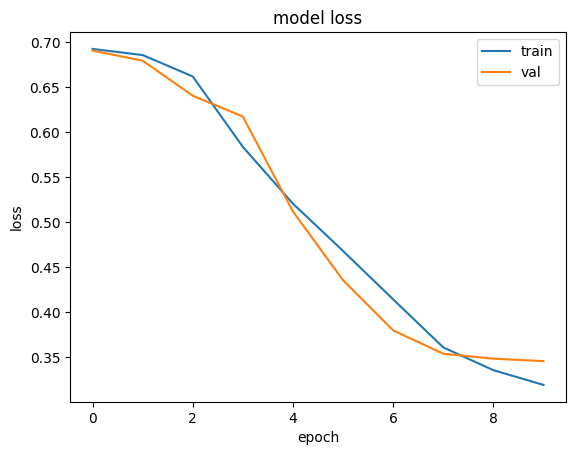

In [ ]:
# Visualize the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

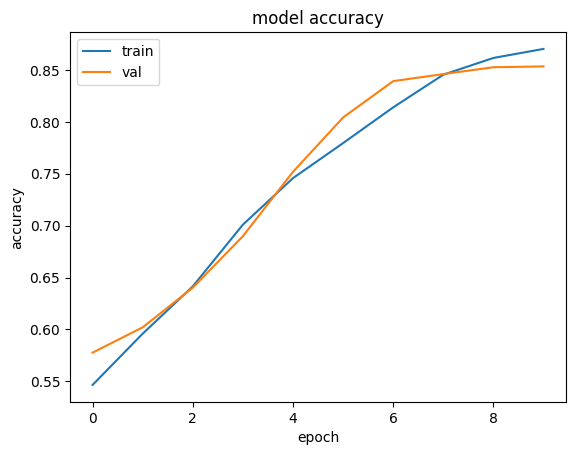

In [ ]:
# Visualize the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 [==============================] - 10s 12ms/step - loss: 0.3434 - accuracy: 0.8556
Test Loss: 0.3433528244495392
Test Accuracy: 0.8555600047111511


In [ ]:
# Make prediction on a new data sample
sample_reviews = [('It is a cool movie. The graphics and the animation are awesome.'),
                  ('The movie was really bad. I would not recommend it to anyone.')]
predictions = model.predict(np.array(sample_reviews))
print(predictions[0])
print(predictions[1])

1/1 [==============================] - 1s 1s/step
[0.7603598]
[0.27050284]


# Bi-Directional

In [11]:
# Initialize RNN model with Bidirectional LSTM layer
bi_model = tf.keras.models.Sequential([
    text_encoder,
    Embedding(
        input_dim = len(text_encoder.get_vocabulary()) + 1,
        output_dim = 64,
        mask_zero = True),
    Bidirectional(layer = LSTM(units = 64)),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    ])

# Summarize model
bi_model.summary()

# Check layer masking
print([layer.supports_masking for layer in bi_model.layers])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,433
Trainable params: 138,433
Non-tr

In [12]:
# Compile the model
bi_model.compile(loss = 'binary_crossentropy',
                 optimizer = tf.keras.optimizers.Adam(1e-3),
                 metrics = ['accuracy'])
# Train the model
bi_history = bi_model.fit(X_train, y_train, epochs = 10, batch_size = 1024, validation_data = (X_val, y_val))

Epoch 1/10
20/20 [==============================] - 22s 407ms/step - loss: 0.6889 - accuracy: 0.5613 - val_loss: 0.6696 - val_accuracy: 0.6426
Epoch 2/10
20/20 [==============================] - 5s 260ms/step - loss: 0.5741 - accuracy: 0.7077 - val_loss: 0.4438 - val_accuracy: 0.8014
Epoch 3/10
20/20 [==============================] - 5s 239ms/step - loss: 0.4125 - accuracy: 0.8196 - val_loss: 0.4167 - val_accuracy: 0.7988
Epoch 4/10
20/20 [==============================] - 5s 262ms/step - loss: 0.3628 - accuracy: 0.8438 - val_loss: 0.3478 - val_accuracy: 0.8528
Epoch 5/10
20/20 [==============================] - 5s 243ms/step - loss: 0.3240 - accuracy: 0.8640 - val_loss: 0.3352 - val_accuracy: 0.8588
Epoch 6/10
20/20 [==============================] - 5s 245ms/step - loss: 0.3126 - accuracy: 0.8693 - val_loss: 0.3347 - val_accuracy: 0.8576
Epoch 7/10
20/20 [==============================] - 5s 268ms/step - loss: 0.3023 - accuracy: 0.8759 - val_loss: 0.3365 - val_accuracy: 0.8564
Epoch

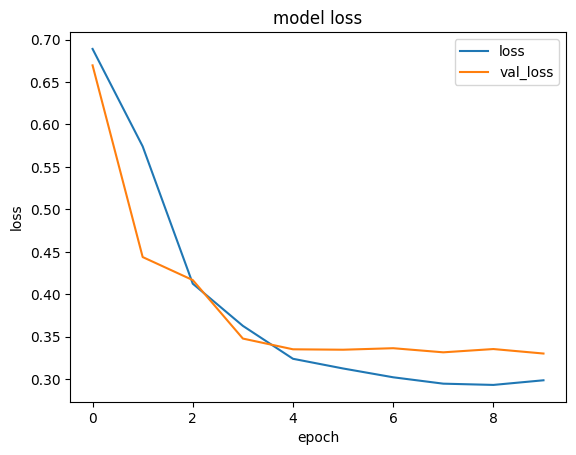

In [15]:
# Visualize the training and validation loss over epochs
plt.plot(bi_history.history['loss'])
plt.plot(bi_history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc = 'upper right')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

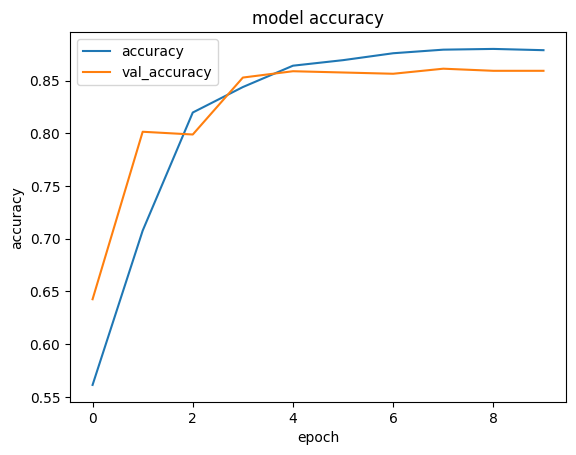

In [16]:
# Visualize the training and validation accuracy over epochs
plt.plot(bi_history.history['accuracy'])
plt.plot(bi_history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc = 'upper left')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [17]:
# Evaluate the model on the test set
test_loss, test_accuracy = bi_model.evaluate(X_test, y_test)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

782/782 [==============================] - 18s 23ms/step - loss: 0.3244 - accuracy: 0.8578
Test loss:  0.324423611164093
Test accuracy:  0.8577600121498108


In [18]:
# Make prediction on a new data sample
sample_reviews = [('It is a cool movie. The graphics and the animation are awesome.'),
                  ('The movie was really bad. I would not recommend it to anyone.')]
bi_predictions = bi_model.predict(np.array(sample_reviews))
print(bi_predictions[0])
print(bi_predictions[1])

1/1 [==============================] - 4s 4s/step
[0.7575606]
[0.24833979]


Based on the results, we can see that Bi-LSTM achieved the highest accuracy, but also had the longest running time. LSTM had a slightly lower accuracy than Bi-LSTM, but still performed better than GRU, while having a similar running time to GRU. GRU had the lowest accuracy of the three models, but had the shortest running time.

# ConV1D

In [ ]:
# Initialize a sequential model since all the layers in the model only have single input and produce single output
model = tf.keras.Sequential([
    text_encoder, # Text encoder layer, i.e., TextVectorization layer
    tf.keras.layers.Embedding( # Text embedding layer, i.e., turns positive integers (indexes) into dense vectors of fixed size.
        input_dim=len(text_encoder.get_vocabulary()), # Get the size of word vocabulary (positive integers), VOCAB_SIZE.
        output_dim=64,
        mask_zero=True), # Whether or not the input value 0 (the zero-padding) should be masked out
        # Hence if mask_zero = True, index 0 cannot be used in the vocabulary (input_dim = vocabulary size + 1)
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'), # Dense layer
    tf.keras.layers.Dense(1, activation='sigmoid') # Classification output
])

# Summarize the model
model.summary()

print([layer.supports_masking for layer in model.layers])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 conv1d (Conv1D)             (None, None, 128)         41088     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.50558895]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val)) # Here the test dataset is used as validtion set

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


625/625 [==============================] - 63s 95ms/step - loss: 0.6847 - accuracy: 0.6066 - val_loss: 0.6530 - val_accuracy: 0.7252
Epoch 2/10
625/625 [==============================] - 14s 22ms/step - loss: 0.5358 - accuracy: 0.7498 - val_loss: 0.4574 - val_accuracy: 0.7876
Epoch 3/10
625/625 [==============================] - 10s 16ms/step - loss: 0.4069 - accuracy: 0.8156 - val_loss: 0.3897 - val_accuracy: 0.8272
Epoch 4/10
625/625 [==============================] - 8s 12ms/step - loss: 0.3518 - accuracy: 0.8459 - val_loss: 0.3589 - val_accuracy: 0.8438
Epoch 5/10
625/625 [==============================] - 9s 14ms/step - loss: 0.3152 - accuracy: 0.8669 - val_loss: 0.3408 - val_accuracy: 0.8520
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 0.2881 - accuracy: 0.8803 - val_loss: 0.3315 - val_accuracy: 0.8552
Epoch 7/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2656 - accuracy: 0.8920 - val_loss: 0.3281 - val_accuracy: 0.8574
Epoch 8

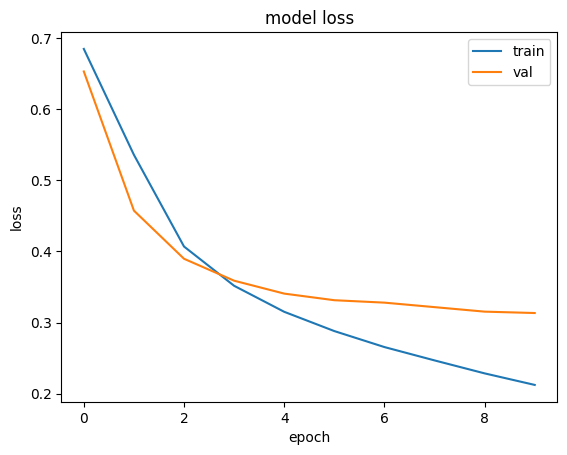

In [ ]:
# Visualize the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

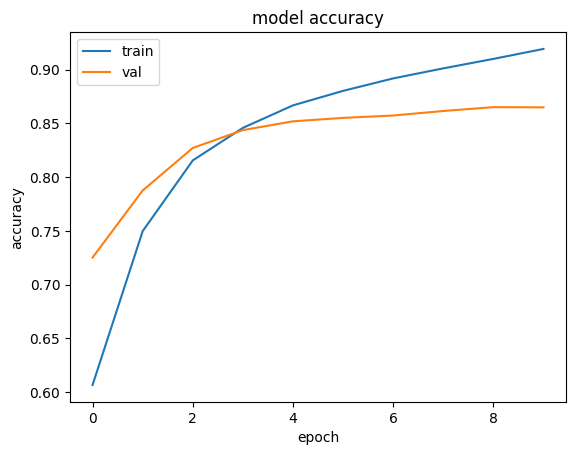

In [ ]:
# Visualize the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 [==============================] - 6s 7ms/step - loss: 0.3091 - accuracy: 0.8658
Test Loss: 0.3090912401676178
Test Accuracy: 0.8657600283622742


In [ ]:
# Make prediction on a new data sample
sample_reviews = [('It is a cool movie. The graphics and the animation are awesome.'),
                  ('The movie was really bad. I would not recommend it to anyone.')]
predictions = model.predict(np.array(sample_reviews))
print(predictions[0])
print(predictions[1])

1/1 [==============================] - 0s 133ms/step
[0.99379915]
[0.00861779]


Convolutional models got the highest accuracy on this sentiment classification task. 1D-Convolutional models tend to have a faster training time compared to Bi-LSTM models.

Meanwhile, the Bi-Directional GRU and LSTM models performed slightly worse in terms of accuracy and had longer training times compared to the Bi-LSTM and 1D-Convolutional models. However, it's worth noting that the differences in accuracy and training time are relatively small

# Glove


In [19]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-05-10 13:37:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-10 13:37:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-10 13:37:11--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [23]:
word_index = dict(zip(vocab, range(len(vocab))))

In [22]:
# Choosing 100-dimensional text-encoded vectors
glove_path = "glove.6B.100d.txt"

# Creating a dictionary mapping words to their NumPy vector from pre-trained GloVe word vectors
embedding_index = {}
with open(glove_path) as f:
  for line in f:
    word, vector = line.split(maxsplit = 1)
    vector = np.fromstring(vector, "f", sep = " ") # Convert string to 1D array
    embedding_index[word] = vector

In [24]:
embedding_dim = 100
hits = 0
misses = 0
num_tokens = VOCAB_SIZE + 2

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
    hits+=1
  else:
    misses +=1

In [25]:
# Creating embedding layer
embedding_layer = Embedding(
    input_dim = num_tokens,
    output_dim = embedding_dim,
    # Generate tensor with constant values
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = False,
    mask_zero = True
)

In [26]:
from tensorflow.keras import layers, models

int_sequences_input = layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = LSTM(units=100)(embedded_sequences)
x = Dense(64, activation = 'relu')(x)
preds = Dense(1, activation = 'sigmoid')(x)
glove_model = models.Model(int_sequences_input, preds)
glove_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         100200    
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 64)                6464      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 187,129
Trainable params: 86,929
Non-trainable params: 100,200
_________________________________________________________________


In [27]:
X_train_glove = text_encoder(np.array([[s] for s in X_train])).numpy()
X_val_glove = text_encoder(np.array([[s] for s in X_val])).numpy()
X_test_glove = text_encoder(np.array([[s] for s in X_test])).numpy()

y_train_glove = np.array(y_train)
y_val_glove = np.array(y_val)
y_test_glove = np.array(y_test)
# Compile the model
glove_model.compile(loss='binary_crossentropy', # Binary classification loss
              optimizer=tf.keras.optimizers.Adam(1e-3), # Optimizer
              metrics=['accuracy']) # Evaluation metric

# Train the model
glove_history = glove_model.fit(X_train_glove, y_train_glove, epochs=20, batch_size = 1024, validation_data=(X_val_glove, y_val_glove))

Epoch 1/20
20/20 [==============================] - 10s 283ms/step - loss: 0.6815 - accuracy: 0.5537 - val_loss: 0.6570 - val_accuracy: 0.6118
Epoch 2/20
20/20 [==============================] - 3s 167ms/step - loss: 0.6041 - accuracy: 0.6792 - val_loss: 0.5480 - val_accuracy: 0.7298
Epoch 3/20
20/20 [==============================] - 3s 168ms/step - loss: 0.5584 - accuracy: 0.7189 - val_loss: 0.5349 - val_accuracy: 0.7380
Epoch 4/20
20/20 [==============================] - 4s 187ms/step - loss: 0.5071 - accuracy: 0.7563 - val_loss: 0.5467 - val_accuracy: 0.7408
Epoch 5/20
20/20 [==============================] - 4s 177ms/step - loss: 0.4895 - accuracy: 0.7666 - val_loss: 0.4998 - val_accuracy: 0.7620
Epoch 6/20
20/20 [==============================] - 3s 168ms/step - loss: 0.5032 - accuracy: 0.7566 - val_loss: 0.4882 - val_accuracy: 0.7648
Epoch 7/20
20/20 [==============================] - 3s 168ms/step - loss: 0.4654 - accuracy: 0.7838 - val_loss: 0.4554 - val_accuracy: 0.7882
Epoch

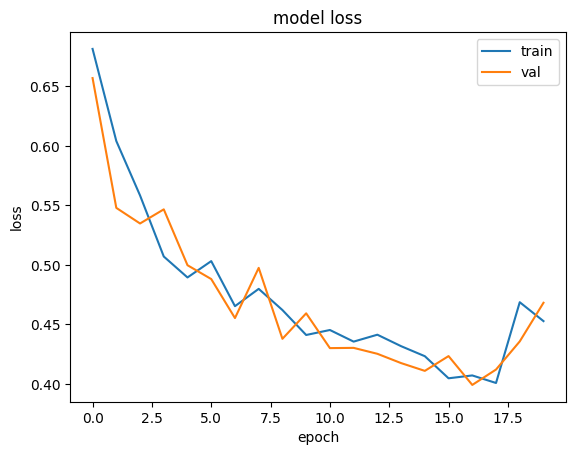

In [28]:
# Visualize the training and validation loss over epochs
plt.plot(glove_history.history['loss'])
plt.plot(glove_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

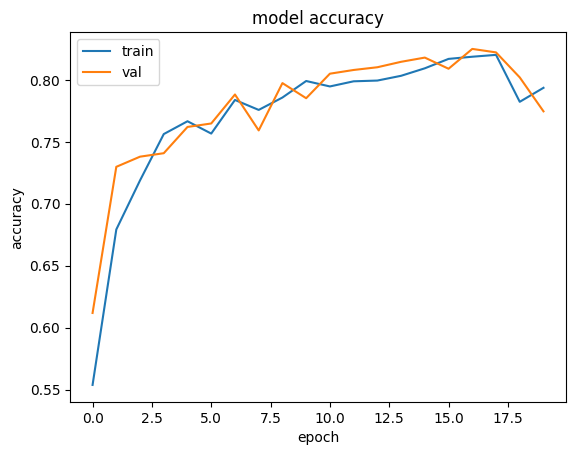

In [29]:
# Visualize the training and validation accuracy over epochs
plt.plot(glove_history.history['accuracy'])
plt.plot(glove_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
# Evaluate the model on the test set

glove_test_loss, glove_test_acc = glove_model.evaluate(X_test_glove, y_test_glove)
print('Test Loss:', glove_test_loss)
print('Test Accuracy:', glove_test_acc)

782/782 [==============================] - 11s 12ms/step - loss: 0.4675 - accuracy: 0.7740
Test Loss: 0.4675411581993103
Test Accuracy: 0.7739999890327454


COnclusion: Using pre-trained GloVe word embeddings does not improve much the performance in terms of accuracy of the sentiment classification model compared to not using them